In [2]:
import pickle

import numpy as np
from rokin import robots, vis
from helper import interpolate_trajectories
from visualize import plot_multiple_trajectories
from sklearn.cluster import KMeans
import pandas as pd

# Now plot me the start coords:
import matplotlib

matplotlib.use("TkAgg")  # Set the backend to TkAgg
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

# Ensure we are using an interactive backend

In [3]:
limits = np.array([[-1.25, +1.25], [-1.25, +1.25], [-1.25, +1.25]])
# Load data:
# pickle load:
raw_path_4123 = pickle.load(open("paths_raw_4123.pkl", "rb"))
world_4123 = pickle.load(open("world_4123.pkl", "rb"))


paths_4123 = np.load("q_paths_4123.npy")
image_4123 = np.load("image_4123.npy")


robot = robots.JustinArm07()
# alternative: three_pv - pyvista; mc meshcat

In [4]:
# interpolate and visualize:
interpol_path = interpolate_trajectories(paths_4123, 25)
print(interpol_path.shape)

(984, 25, 7)


In [5]:
# Now I want to transform the q values to the world coordinates:

frames = robot.get_frames(interpol_path)
print(frames.shape)

(984, 25, 8, 4, 4)


In [6]:
# Extract the X,Y,Z coordinates of the end effector stored for each waypoint of a path as the coordinates
start_coords = []
end_coords = []


for i in range(984):
    start = frames[i, 0, 7, :, :]
    end = frames[i, -1, 7, :, :]
    # Extract the X, Y, Z coordinates (assuming they are in the last row and first three columns)
    x_start = start[0, 3]
    y_start = start[1, 3]
    z_start = start[2, 3]

    x_end = end[0, 3]
    y_end = end[1, 3]
    z_end = end[2, 3]

    start_coords.append([x_start, y_start, z_start])
    end_coords.append([x_end, y_end, z_end])







984


In [8]:
# Initialize the trajectories list
trajectories = []
# Transform the lists into the desired structure
for start, end in zip(start_coords, end_coords):
    trajectories.append({"start": start, "end": end})

print(len(trajectories))
# Define the boundaries for 3D
x_boundaries = [-1.0, 0.0, 1.0]
y_boundaries = [-1.0, 0.0, 1.0]
z_boundaries = [-1, 0.0, 1.0]
# Define regions
regions = {}
index = 1
for i in range(2):
    for j in range(2):
        for k in range(2):
            region_name = f"R_{i+1}{j+1}{k+1}"
            regions[region_name] = {
                "x": (x_boundaries[i], x_boundaries[i + 1]),
                "y": (y_boundaries[j], y_boundaries[j + 1]),
                "z": (z_boundaries[k], z_boundaries[k + 1]),
            }
            index += 1


# Function to determine the region of a point
def find_region(point):
    for region, bounds in regions.items():
        # print(f"Bounds: {bounds}")
        # print(f"Point:{point}")
        if (
            bounds["x"][0] <= point[0] < bounds["x"][1]
            and bounds["y"][0] <= point[1] < bounds["y"][1]
            and bounds["z"][0] <= point[2] < bounds["z"][1]
        ):
            return region

    print(f"No region found for point: {point}")
    print(f"Bound: {bounds}")
    return None


# Cluster trajectories
clusters = {
    region: {other_region: {"count": 0, "indices": []} for other_region in regions}
    for region in regions
}
print(clusters)
for idx, trajectory in enumerate(trajectories):
    start_region = find_region(trajectory["start"])
    end_region = find_region(trajectory["end"])
    if start_region and end_region:
        clusters[start_region][end_region]["count"] += 1
        clusters[start_region][end_region]["indices"].append(idx)

    else:
        print("No matching region found")
        # print(trajectory["start"])
        # print(trajectory["end"])


cluster_counts = {
    region: {
        other_region: clusters[region][other_region]["count"]
        for other_region in regions
    }
    for region in regions
}
clusters_df = pd.DataFrame(cluster_counts).T
print(clusters_df)

{'R_111': {'R_111': {'count': 0, 'indices': []}, 'R_112': {'count': 0, 'indices': []}, 'R_121': {'count': 0, 'indices': []}, 'R_122': {'count': 0, 'indices': []}, 'R_211': {'count': 0, 'indices': []}, 'R_212': {'count': 0, 'indices': []}, 'R_221': {'count': 0, 'indices': []}, 'R_222': {'count': 0, 'indices': []}}, 'R_112': {'R_111': {'count': 0, 'indices': []}, 'R_112': {'count': 0, 'indices': []}, 'R_121': {'count': 0, 'indices': []}, 'R_122': {'count': 0, 'indices': []}, 'R_211': {'count': 0, 'indices': []}, 'R_212': {'count': 0, 'indices': []}, 'R_221': {'count': 0, 'indices': []}, 'R_222': {'count': 0, 'indices': []}}, 'R_121': {'R_111': {'count': 0, 'indices': []}, 'R_112': {'count': 0, 'indices': []}, 'R_121': {'count': 0, 'indices': []}, 'R_122': {'count': 0, 'indices': []}, 'R_211': {'count': 0, 'indices': []}, 'R_212': {'count': 0, 'indices': []}, 'R_221': {'count': 0, 'indices': []}, 'R_222': {'count': 0, 'indices': []}}, 'R_122': {'R_111': {'count': 0, 'indices': []}, 'R_112

In [9]:
# Sum all entries in the dataframe
total = clusters_df.sum().sum()
print(total)

# Example for the indices of Cluster R_111 to R_111
print(clusters["R_212"]["R_212"]["indices"])

984
[18, 68, 77, 136, 148, 185, 212, 299, 302, 310, 313, 325, 344, 345, 368, 376, 399, 402, 409, 417, 451, 454, 460, 491, 513, 540, 574, 578, 601, 605, 656, 661, 676, 714, 717, 732, 752, 756, 761, 780, 866, 920, 934, 945]


In [10]:
frames_0 = frames[clusters["R_212"]["R_212"]["indices"]]

# Visualize the first cluster
plot_multiple_trajectories(frames_0, 10)

(10,)
(44, 25, 8, 4, 4)
Sampled paths shape: (10, 25, 8, 4, 4)


In [11]:
start_coords = np.array(start_coords)
end_coords = np.array(end_coords)

print(start_coords.shape)
print(end_coords.shape)

# Do some statistics min max on this data:
print("Start coords:")
print(np.min(start_coords, axis=0))
print(np.max(start_coords, axis=0))
print("End coords:")
print(np.min(end_coords, axis=0))
print(np.max(end_coords, axis=0))

(984, 3)
(984, 3)
Start coords:
[-0.86240749 -0.86784848 -0.65950105]
[0.86684865 0.86816817 0.74463552]
End coords:
[-0.86400766 -0.86919334 -0.63381689]
[0.88061599 0.89835292 0.76327208]


In [12]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection="3d")
# ax.scatter(start_coords[:, 0], start_coords[:, 1], start_coords[:, 2], color="r")
# ax.scatter(end_coords[:, 0], end_coords[:, 1], end_coords[:, 2], color="b")
# plt.show()

In [13]:
# Combine start and end coordinates into a single feature vector for each trajectory
trajectory_features = [start + end for start, end in zip(start_coords, end_coords)]
trajectory_features = np.array(trajectory_features)

# Define the number of clusters
num_clusters = 8

# Apply k-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(trajectory_features)

# Get cluster labels
labels = kmeans.labels_

In [14]:
# Cound the distribution of labels
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

# Store the indices of each cluster ina dictionary
cluster_indices = {}
for i in range(num_clusters):
    cluster_indices[i] = np.where(labels == i)[0]

{np.int32(0): np.int64(127), np.int32(1): np.int64(100), np.int32(2): np.int64(88), np.int32(3): np.int64(211), np.int32(4): np.int64(105), np.int32(5): np.int64(110), np.int32(6): np.int64(131), np.int32(7): np.int64(112)}


In [15]:
# RETRIEVE THE PATHS OF THE FIRST CLUSTER
frames_0 = frames[cluster_indices[1]]


# Visualize the first cluster
plot_multiple_trajectories(frames_0, 10)

(10,)
(100, 25, 8, 4, 4)
Sampled paths shape: (10, 25, 8, 4, 4)


/Users/magic-rabbit/Documents/ADLR/tum-adlr-ss24-18/justin_arm/visualize.py:132: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


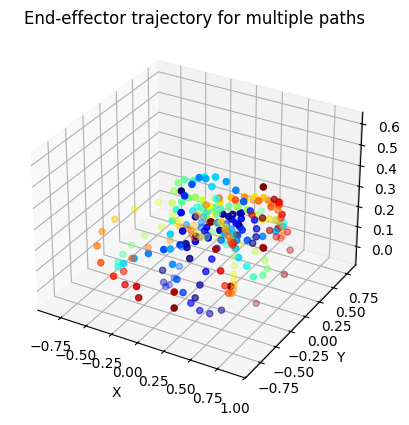

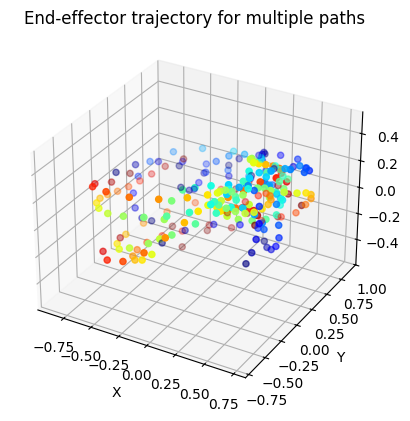

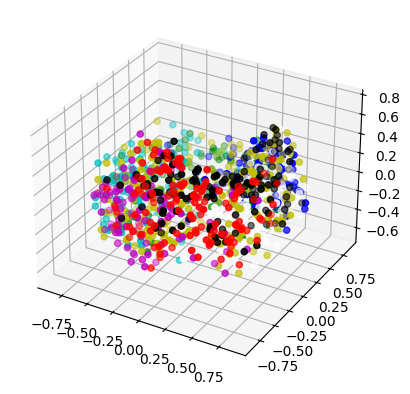

<Figure size 640x480 with 0 Axes>

In [16]:
%matplotlib inline 

# Given the labels for each trajectory, we can now plot the trajectories in different colors
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
colors = ["r", "g", "b", "y", "c", "m", "k", "w"]
for i in range(num_clusters):
    ax.scatter(
        start_coords[labels == i, 0],
        start_coords[labels == i, 1],
        start_coords[labels == i, 2],
        color=colors[i],
    )

plt.show()
plt.savefig("start_coords.png")

In [17]:
# # Visualize:
# vis.three_mc.animate_path(
#     robot=robot,
#     q=paths_4123[10],
#     kwargs_robot=dict(color="red", alpha=0.2),
#     kwargs_world=dict(img=image_4123[0], limits=limits, color="yellow"),
# )
# input()

# # vis.three_pv.animate_path(robot=robot, q=q_paths[0],
# #                           kwargs_world=dict(img=obstacle_images[2], limits=limits))

# # move through animation with arrow keys